## Importing Files

In [1]:
%cd mycourse/skills

/home/chris/data/untitled/python/mycourse/skills


In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
from skills_ml.storage import InMemoryStore
from skills_ml.ontologies import Competency
from skills_ml.ontologies.viz import display_nodes
from skills_ml.ontologies import Occupation
from skills_ml.ontologies import CompetencyOntology
from skills_ml.ontologies.viz import display_ontology

from skills_ml.algorithms.skill_extractors import (
    FuzzyMatchSkillExtractor,
    ExactMatchSkillExtractor,
    SocScopedExactMatchSkillExtractor,
    SectionExtractSkillExtractor,
    SkillEndingPatternExtractor,
    AbilityEndingPatternExtractor
)

from skills_ml.ontologies.onet import Onet
from skills_ml.evaluation.skill_extractors import candidate_skills_from_sample, metrics_for_candidate_skills
from skills_ml.evaluation.skill_extraction_metrics import TotalOccurrences, TotalVocabularySize, OntologyCompetencyRecall
from skills_ml.job_postings.common_schema import JobPostingCollectionSample as VriginaJobPosting

from io import BytesIO
import json
import pandas as pd
import numpy as np
import os
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import pickle
from collections import Counter
from nltk.corpus import stopwords
from utils import *

db_dir = "db"

## Dynamic Scraping

#### ONET: Data scraped from https://www.onetcenter.org/database.html#t2

In [20]:
onet = Onet()
onet.print_summary_stats()

Ontology summary statistics for onet
Num competencies: 32030
Num occupations: 1133
Num competency-occupation edges: 107305
Median occupations per competency: 1
Median competencies per occupation: 89
Mean occupations per competency: 3.350245090386837
Mean competencies per occupation: 94.70873786407768


Internall it is stored as a huge biparite graph, where 

$$V = \{ occupations \} \oplus \{ skills \}$$

Below is the graph representation of skills required by mathematicians

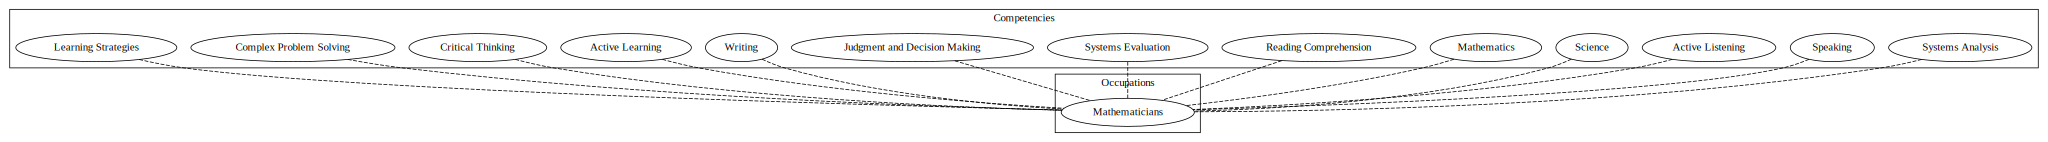

In [30]:
mathematicans = onet.filter_by(
    lambda edge: "Mathematicians" in edge.occupation.name \
                and "Skills" in edge.competency.categories
)
display_ontology(mathematicans)

Here, we compare the skills presented in the live ONET data scaped vs. your database. The information is consistent.

In [7]:
csv_dir = "nlp_csv"
careerinfo = pd.read_csv(os.path.join(db_dir, csv_dir, "CareerInfoEntity.csv"))
careers = set(careerinfo["career"].str.slice(0,10))
competency = pd.read_csv(os.path.join(db_dir, csv_dir, "CompetencyEntity.csv"))
skills ={comp.name for comp in onet.competencies if 'Skills' in comp.categories}
abilities ={comp.name for comp in onet.competencies if 'Abilities' in comp.categories}
knowledge={comp.name for comp in onet.competencies if 'Knowledge' in comp.categories}

print(len(set(careers) - {occ.identifier for occ in onet.occupations}) == 0)
for type, df in zip(["skill", "ability", "knowledge"], [skills, abilities, knowledge]):
    print(len(set(competency[competency["entityType"]==type]["name"]) - df)==0)

print(len({occ.identifier for occ in onet.occupations} - set(careers)))
for type, df in zip(["skill", "ability", "knowledge"], [skills, abilities, knowledge]):
    print(len( df - set(competency[competency["entityType"]==type]["name"]) ))

True
True
True
True
306
35
52
33


Our database sync with the Onet database

In [70]:
for KSAT in ["Knowledge", "Skills", "Abilities", "Tools"]:
    mathematicans = onet.filter_by(
        lambda edge: "Mathematicians" in edge.occupation.name \
                    and KSAT in edge.competency.categories
    )
    print(len(mathematicans.competencies), KSAT + ":")
    for c in mathematicans.competencies:
        print("\t", c.name)

5 Knowledge:
	 Engineering and Technology
	 English Language
	 Mathematics
	 Physics
	 Computers and Electronics
13 Skills:
	 Critical Thinking
	 Systems Evaluation
	 Writing
	 Science
	 Complex Problem Solving
	 Judgment and Decision Making
	 Learning Strategies
	 Mathematics
	 Reading Comprehension
	 Active Learning
	 Speaking
	 Systems Analysis
	 Active Listening
18 Abilities:
	 Written Expression
	 Oral Expression
	 Deductive Reasoning
	 Number Facility
	 Category Flexibility
	 Information Ordering
	 Near Vision
	 Speech Recognition
	 Flexibility of Closure
	 Oral Comprehension
	 Speech Clarity
	 Mathematical Reasoning
	 Selective Attention
	 Inductive Reasoning
	 Problem Sensitivity
	 Fluency of Ideas
	 Written Comprehension
	 Originality
7 Tools:
	 Universal serial bus USB flash drives
	 Optical disk drives
	 Laptop computers
	 Personal computers
	 Supercomputers
	 Graphing calculators
	 Desktop computers


#### Now, we are shifting our scraping to aggreagate skills from job posts. This allows us to extract skills from any job posting website, such as LinkedIn. Here are the websites/datasets we are currently extracting from:

- LinkedIn

- Onet

- Kaggle: contains 19,000 [job postings](https://www.kaggle.com/madhab/jobposts) that were posted through the Armenian human resource portal CareerCenter.

- USAJobs: Use [JobPosting schema](https://schema.org/JobPosting) fetched from USAJobs using its API
    
- Vrigina Dataset: [website](https://opendata-cs-vt.github.io/ccars-jobpostings/) is down currently, but we found a small collections of pre-processed samples

Below are a few sample job postings

In [8]:
linkedin = pd.read_csv(os.path.join(db_dir, "2020-12-09-linkedin.csv"), encoding="ISO-8859-1")
linkedin.head(2)

,Unnamed: 0,Job ID,Date,Company Name,Post,Location,Description,Level,Type,Function,Industry
0,0,2322352378,2020-12-09,Jobot,Senior Front End Software Engineer,"Irvine, CA",Direct message the job poster from Jobot Reed ...,Mid-Senior level,Full-time,EngineeringInformation Technology,Information Technology and ServicesComputer So...
1,1,2322351571,2020-12-09,Jobot,Senior Front End Software Engineer,"Los Angeles, CA",Direct message the job poster from Jobot Reed ...,Mid-Senior level,Full-time,EngineeringInformation Technology,Information Technology and ServicesComputer So...


In [11]:
kaggle = pd.read_csv(os.path.join(db_dir, "data job posts.csv"))
kaggle.head(2)

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False


In [13]:
with open('db/USAJobPostings.pkl', 'rb') as f:
    usajobs = pickle.load(f)
usajobs[0]

{'MatchedObjectId': '451842500',
 'MatchedObjectDescriptor': {'PositionID': 'OARMAV1',
  'PositionTitle': 'Attorney and Assistant United States Attorney',
  'PositionURI': 'https://www.usajobs.gov:443/GetJob/ViewDetails/451842500',
  'ApplyURI': ['https://www.usajobs.gov:443/GetJob/ViewDetails/451842500?PostingChannelID=RESTAPI'],
  'PositionLocationDisplay': 'Washington, District of Columbia',
  'PositionLocation': [{'LocationName': 'Washington, District of Columbia',
    'CountryCode': 'United States',
    'CountrySubDivisionCode': 'District of Columbia',
    'CityName': 'Washington, District of Columbia',
    'Longitude': -77.032,
    'Latitude': 38.8904}],
  'OrganizationName': 'Offices, Boards and Divisions',
  'DepartmentName': 'Department of Justice',
  'JobCategory': [{'Name': 'Attorney', 'Code': '0905'}],
  'JobGrade': [{'Code': 'GS'}],
  'PositionSchedule': [{'Name': 'Full Time', 'Code': '1'}],
  'PositionOfferingType': [{'Name': 'Multiple Appointment Types',
    'Code': '153

In [18]:
Vrigina = VriginaJobPosting()
print(next(iter(Vrigina)))

{'@context': 'http://schema.org', '@type': 'JobPosting', 'title': 'Media Consultant', 'description': "Media consultant. Email. tweet. Location:Vienna, Va.. Date posted: 03-11-2016. Apply now. Job Summary: the Public Sector Group, a division of 1105 media, is seeking an experienced media consultant sales professional who enjoys a fast-paced leading edge environment and a variety of assignments with an innovative media company. The Media Consultant & Sales Representative will support a myriad of online and print products providing a genuine relational and consultative approach with customers to foster repeat business. The portfolio includes print publications, websites, e-newsletters, web seminars, custom media, research and other Online & print products. This position involves business development and account prospecting, face-to-face and phone selling, networking at industry events, putting together and making presentations, preparing proposals, closing sales, managing print and online

#### Data cleaning

From the sample job above, we start by cleaning the data. We focus our efforts here to just the job description. Most of the skills are nouns ,verbs, and adjectives, but we can focus ony on jobs moving forward potentially.
forcus on job description. You can see some sample job posts below.

n gram, freq > 1, 

In [21]:
linkedin = pd.read_csv("db/2020-12-09-linkedin.csv", encoding="ISO-8859-1")
linkedin.head(2)

,Unnamed: 0,Job ID,Date,Company Name,Post,Location,Description,Level,Type,Function,Industry
0,0,2322352378,2020-12-09,Jobot,Senior Front End Software Engineer,"Irvine, CA",Direct message the job poster from Jobot Reed ...,Mid-Senior level,Full-time,EngineeringInformation Technology,Information Technology and ServicesComputer So...
1,1,2322351571,2020-12-09,Jobot,Senior Front End Software Engineer,"Los Angeles, CA",Direct message the job poster from Jobot Reed ...,Mid-Senior level,Full-time,EngineeringInformation Technology,Information Technology and ServicesComputer So...


In [ ]:
cleansing(linkedin["Description"], 
          index = pd.MultiIndex.from_frame(linkedin[["Company Name", "Post", "Location"]]),
          output_path = "db/linkedin-CV.h5").head(2)

In [23]:
job_posting = pd.read_csv("db/data job posts.csv")
job_posting.head(2)

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False


In [24]:
job_posting.columns

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')

In [25]:
job_posting[job_posting["Company"]=="Orange Armenia"].iloc[:3]["RequiredQual"].iloc[0]

'- Higher education (psychological, sociological background is\r\npreferred);\r\n- 2-3 years of work experience in the related area;\r\n- MS Office (Word, Excel, Power Point, Access, Outlook) and Internet\r\nnavigation skills;\r\n- Advanced level in English and Russian languages.'

Most popular companies in our job posting sample dataset.

In [26]:
job_posting["Company"].value_counts()

ArmenTel CJSC                                353
World Vision Armenia                         239
Mentor Graphics Development Services CJSC    236
Career Center NGO                            229
Orange Armenia                               203
                                            ... 
Aspid Technologies Co. Ltd                     1
AG Print LLC                                   1
"Mikmax" LLC                                   1
Avata Soft LLC                                 1
Ayvazyan and Partners LLC                      1
Name: Company, Length: 4554, dtype: int64

### EDA

In this section, we do some early analysis on the job posting data, looking for keywords and thier assocaited spatial relationships tht can help us come up with ideas for scores. In the analysis below, we focus only on "software engineering", but the methods are generalizable to any job.

In [27]:
df = pd.read_hdf("db/linkedin-CV.h5")
df = df.transpose()
df.head(5)

Company Name                              Jobot                               \
Post         Senior Front End Software Engineer                                
Location                             Irvine, CA Los Angeles, CA San Jose, CA   
aaa                                           0               0            0   
ability                                       0               0            0   
able                                          0               0            0   
accept                                        0               0            0   
access                                        0               0            0   

Company Name                                                           \
Post         Sr. Software Engineer Senior Front End Software Engineer   
Location           Los Angeles, CA                  San Francisco, CA   
aaa                              0                                  0   
ability                          0                                  0   
able                             1                                  0   
accept                           0                                  0   
access                           1                                  0   

Company Name                                       RealREPP  \
Post                                      Software Engineer   
Location     Sacramento, CA San Diego, CA   Los Angeles, CA   
aaa                       0             0                 0   
ability                   0             0                 0   
able                      0             0                 0   
accept                    0             0                 0   
access                    0             0                 0   

Company Name                                                 Fisker Inc  ...  \
Post         Software Development Engineer Full Stack Software Engineer  ...   
Location                        Irvine, CA          Manhattan Beach, CA  ...   
aaa                                      0                            0  ...   
ability                                  0                            0  ...   
able                                     0                            0  ...   
accept                                   0                            0  ...   
access                                   0                            0  ...   

Company Name                               Intelletec  \
Post                               Senior UX Engineer   
Location     San Francisco, California, United States   
aaa                                                 0   
ability                                             0   
able                                                0   
accept                                              0   
access                                              0   

Company Name                                               Google  \
Post         Staff Software Engineer, Video Framework, Android OS   
Location                 Mountain View, California, United States   
aaa                                                           0     
ability                                                       0     
able                                                          0     
accept                                                        0     
access                                                        0     

Company Name                               Cisco  \
Post            Software Engineer - Transmission   
Location     Milpitas, California, United States   
aaa                                            0   
ability                                        0   
able                                           0   
accept                                         0   
access                                         0   

Company Name                                           PlayStation  \
Post         Staff Network Software Engineer, Developer Technology   
Location                      San Mateo, California, United S

Top 3 most common words in job descriptions

In [28]:
jobs_most_common_words = {}
for job in df.columns:
    top3 = df[job].sort_values(ascending=False).head(3)
    jobs_most_common_words[job] = list(zip(top3.index, top3.values))

In [29]:
# common words for PlayStation
playStation_jobs = df.columns[df.columns.get_loc("PlayStation")]
for job in playStation_jobs:
    print(jobs_most_common_words[job])

[('game', 5), ('playstation', 5), ('network', 4)]
[('playstation', 11), ('security', 9), ('sony', 7)]
[('playstation', 5), ('sony', 3), ('opportunity', 3)]
[('sony', 7), ('status', 6), ('us', 5)]
[('playstation', 5), ('sony', 4), ('application', 4)]


Most common words for all jobs

In [30]:
words = []
for common_words in jobs_most_common_words.values():
    for word, _ in common_words:
        words.append(word)
        
Counter(words).most_common(10)

[('top', 13),
 ('developers', 12),
 ('toptal', 12),
 ('job', 7),
 ('jobot', 6),
 ('kellick', 6),
 ('apply', 5),
 ('work', 4),
 ('playstation', 4),
 ('sony', 4)]

Generate word clouds to visualzie most common words.

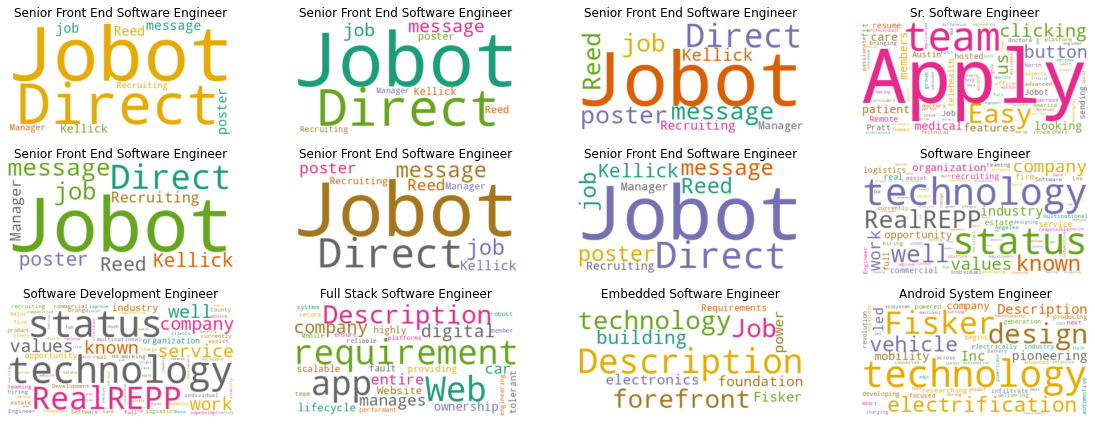

In [31]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stopwords.words("english"),
               background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [16, 6]

max_subplot = 12
for index, job in enumerate(df.columns):
    if index + 1 > max_subplot:
        break
        
    company, job, location = job
    wc.generate(linkedin.query(
        "`Company Name`==@company & `Post`==@job & `Location`==@location"
    )["Description"].iloc[0])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(job)
    
plt.tight_layout()

Note:

- Description always has the name of the company (expected)

- Apply is a common word

For length of each description (pre-cleansing)

In the future, we can grop further by role.

In [32]:
avg_desc_len = np.mean(list(map(len, linkedin["Description"])))
avg_desc_len

1437.4285714285713

In [33]:
company_avg_desc_len = linkedin.groupby("Company Name")["Description"].\
        apply(
    lambda descriptions: np.mean([len(desc) for desc in descriptions])
)

In [34]:
company_avg_desc_len.values

array([1600.        , 3725.        ,  375.        ,  428.33333333,
       2191.        ,  971.        ,  108.        ,  213.85714286,
         52.        , 1813.42857143, 2975.5       , 2587.        ,
        998.5       ,  834.        , 3714.        , 1265.        ])

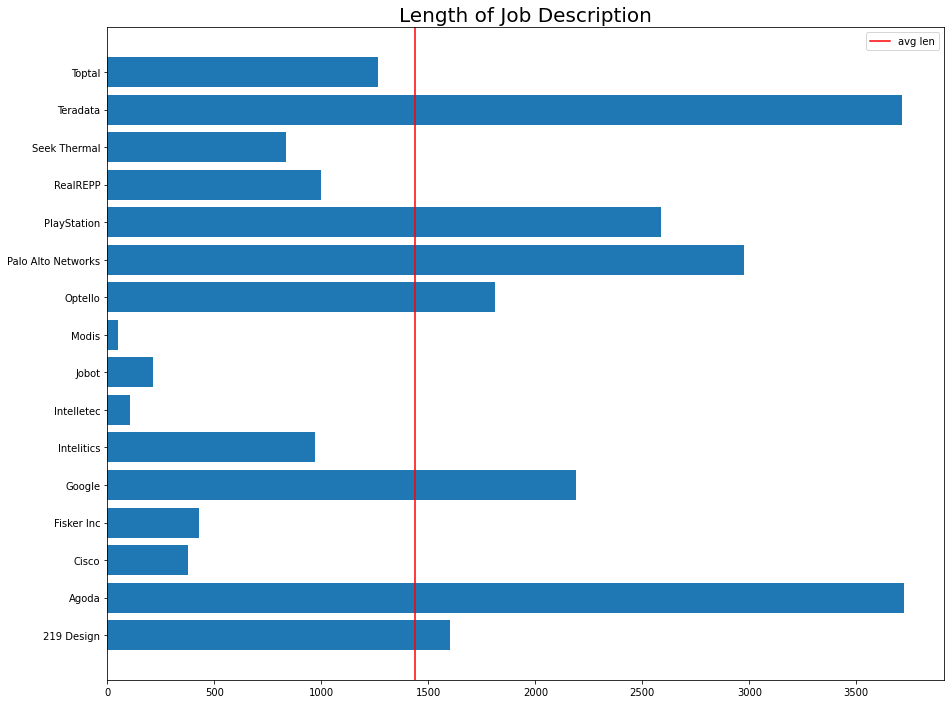

In [35]:
y_pos = np.arange(len(company_avg_desc_len))
plt.figure(figsize=(15,12))
plt.barh(y_pos, company_avg_desc_len.values, align='center')
plt.yticks(y_pos, company_avg_desc_len.index)
plt.title('Length of Job Description', fontsize=20)

plt.axvline(avg_desc_len, color='r', label="avg len")
plt.legend()
plt.show()

How many times `software` word show up in job descriptions of software engineer? And how many times `techonology` show up?

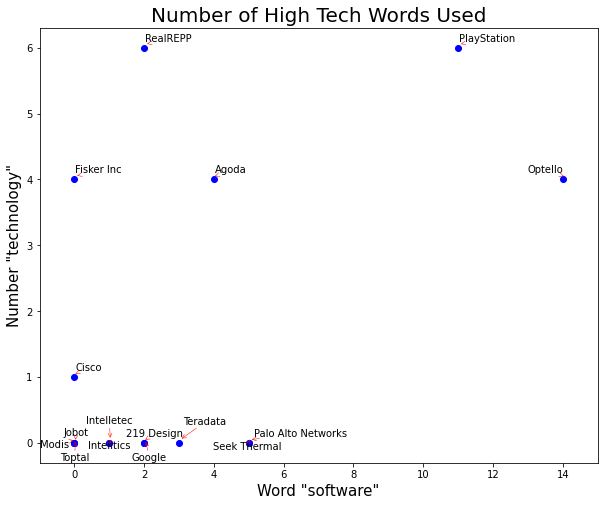

In [36]:
from adjustText import adjust_text

high_tech_words = df.transpose()[["software", "technology"]].\
            groupby("Company Name").sum()

# Let's create a scatter plot of our findings
plt.rcParams['figure.figsize'] = [10, 8]

texts = []
for (company, (software_ct, tech_ct)) in high_tech_words.iterrows():
    plt.scatter(software_ct, tech_ct, color='blue')
    texts.append(plt.text(software_ct+0.03, tech_ct+0.05, company, fontsize=10))
    plt.xlim(-1, 15)

adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    
plt.title('Number of High Tech Words Used', fontsize=20)
plt.xlabel('Word "software"', fontsize=15)
plt.ylabel('Number "technology"', fontsize=15)

plt.show()

### Skill Extractors

Currently we are using three kinds of skill extractors:

1. Grammer based NP Chunking

2. Exact match (use [Trie](https://stackoverflow.com/questions/42742810/speed-up-millions-of-regex-replacements-in-python-3/42789508#42789508) to speed up)
3. Fuzzy search (fork of [symspell](https://github.com/wolfgarbe/SymSpell))


Using Virginia Dataset.

In the work below, we demonstrte the ability to extract skills from any generic job posting website. 

In [2]:
class Sample(object):
    def __init__(self, storage, sample_name):
        self.storage = storage
        self.name = sample_name

    @property
    def base_path(self):
        return self.storage.path

    def __iter__(self):
        fh = BytesIO(self.storage.load(self.name))
        for line in fh:
            yield line

    def __len__(self):
        return sum(1 for item in self)


def sample_factory(job_postings, name='asample', storage=None):
    if not storage:
        storage = InMemoryStore()
    storage.write(
        '\n'.encode('utf-8').join(json.dumps(job_posting).encode('utf-8') for job_posting in job_postings),
        name
    )
    return Sample(storage, name)

In [24]:
sample = sample_factory(VriginaJobPosting())
print('Building ONET, may take a while to download')
# full_onet = Onet()
full_onet = onet

skill_extractors = [
    # SectionExtractSkillExtractor(),
    SkillEndingPatternExtractor(only_bulleted_lines=False),
    AbilityEndingPatternExtractor(only_bulleted_lines=False),
    # Symmetric Delete spelling correction algorithm
    FuzzyMatchSkillExtractor(full_onet.competency_framework),
    ExactMatchSkillExtractor(full_onet.competency_framework),
    SocScopedExactMatchSkillExtractor(full_onet)
]
print('Done building ONET! Now subsetting ONET into K,S,A')
metric_ontologies = [
    full_onet,
    full_onet.filter_by(lambda edge: 'Knowledge' in edge.competency.categories, competency_name='onet_knowledge', competency_description='ONET Knowledge'),
    full_onet.filter_by(lambda edge: 'Abilities' in edge.competency.categories, competency_name='onet_ability', competency_description='ONET Ability'),
    full_onet.filter_by(lambda edge: 'Skills' in edge.competency.categories, competency_name='onet_skill', competency_description='ONET Skill')
]
metrics = [
    TotalOccurrences(),
    TotalVocabularySize(),
]
for metric_ontology in metric_ontologies:
    # The percentage of competencies in an ontology which are present in the candidate skills
    metrics.append(OntologyCompetencyRecall(metric_ontology))

Building ONET, may take a while to download
Done building ONET! Now subsetting ONET into K,S,A


In [ ]:
results = []
for skill_extractor in skill_extractors:
    print(f'Evaluating skill extractor {skill_extractor.name}')
    candidate_skills = candidate_skills_from_sample(sample, skill_extractor)

    computed_metrics = metrics_for_candidate_skills(
        candidate_skills=candidate_skills,
        sample=sample,
        metrics=metrics
    )
    print(computed_metrics)
    results.append(computed_metrics)

In the table below, you can see the precision/recall figures. The low recall is due to the very high number of skill sin the dataset. moving forwards, we will try clustering of skills to lower this figure.

In [32]:
metric_names = results[0].keys()
skill_extractor_metric = []
for i, skill_extractor in enumerate(skill_extractors):
    skill_extractor_metric.append([
        results[i][name]
        for name in metric_names
    ])
skill_extractor_metric_df = pd.DataFrame(
    skill_extractor_metric,
    columns=metric_names,
    index=[skill_extractor.name for skill_extractor in skill_extractors]
)
skill_extractor_metric_df

,total_candidate_skills,total_vocabulary_size,onet_ksat_competency_recall,onet_knowledge_competency_recall,onet_ability_competency_recall,onet_skill_competency_recall
noun_phrase_skill,49,19,0.000000,0.000000,0.000000,0.000000
noun_phrase_ability,19,5,0.000000,0.000000,0.000000,0.000000
onet_ksat_fuzzy_thresh88_maxdist4_maxngram5,145,41,0.001280,0.121212,0.019231,0.257143
onet_ksat_exact_match,153,40,0.001249,0.121212,0.019231,0.257143
onet_ksat_occscoped_exact_match,55,12,0.000375,0.121212,0.000000,0.171429


In [41]:
skill_extractor_metric_df.iloc[:,0]

noun_phrase_skill                               49
noun_phrase_ability                             19
onet_ksat_fuzzy_thresh88_maxdist4_maxngram5    145
onet_ksat_exact_match                          153
onet_ksat_occscoped_exact_match                 55
Name: total_candidate_skills, dtype: int64

In [56]:
best = skill_extractors[np.argmax(skill_extractor_metric_df.iloc[:,0])]
for s in sample:
    for i in best.candidate_skills(json.loads(s)):
        print("skill: ", i.skill_name, ", id", i.matched_skill_identifier)

skill:  self , id 43232405-Self
skill:  self , id 43232405-Self
skill:  calendars , id 44112002
skill:  impact , id 43232610-ImPACT
skill:  player , id 43232701-Player
skill:  calendars , id 44112002
skill:  impact , id 43232610-ImPACT
skill:  player , id 43232701-Player
skill:  levels , id 27111802-Levels
skill:  time management , id 2.B.5.a
skill:  levels , id 27111802-Levels
skill:  time management , id 2.B.5.a
skill:  trucks , id 25101507-Trucks
skill:  levels , id 27111802-Levels
skill:  mechanical , id 2.C.3.e
skill:  time management , id 2.B.5.a
skill:  automobiles , id 25101503-Automobiles
skill:  brakes , id 23251502-Brakes
skill:  automobiles , id 25101503-Automobiles
skill:  automobiles , id 25101503-Automobiles
skill:  installation , id 2.B.3.d
skill:  automobiles , id 25101503-Automobiles
skill:  automobiles , id 25101503-Automobiles
skill:  auto , id 43232605-AUTO
skill:  time management , id 2.B.5.a
skill:  brakes , id 23251502-Brakes
skill:  mechanical , id 2.C.3.e
skil

Sample competencies extraacted:

In [60]:
onet_competencies = set(
            competency
            for competency in full_onet.competency_framework.values()
            if competency.name
        )
for c in onet_competencies:
    if c.identifier == "2.B.3.e":
        print(c)
onet.competency_framework.competencies["2.B.3.e"]

Competency(identifier=2.B.3.e, name=Programming, categories=['Skills'], {'competencyText': 'Writing computer programs for various purposes.'})


Competency(identifier=2.B.3.e, name=Programming, categories=['Skills'], {'competencyText': 'Writing computer programs for various purposes.'})

What occupations need programming?

In [129]:
for edge in onet._competency_occupation_edges:
    if "2.B.3.e" in edge.competency.identifier:
        print(edge.occupation.name)

Physicists
Clinical Data Managers
Biomedical Engineers
Computer Systems Engineers/Architects
Web Administrators
Software Quality Assurance Engineers and Testers
Mathematical Technicians
Video Game Designers
Statisticians
Computer Systems Analysts

Network and Computer Systems Administrators
Bioinformatics Technicians
Computer Numerically Controlled Machine Tool Programmers, Metal and Plastic
Software Developers, Applications
Computer and Information Research Scientists
Statistical Assistants
Biostatisticians
Social Science Research Assistants
Database Administrators
Computer Programmers
Web Developers
Database Architects
Robotics Engineers


In [139]:
class SampleJobPosting():
    def __init__(self, sample):
        self.sample = sample
    def __iter__(self):
        for s in self.sample:
            yield json.loads(s)

Computer and Mathematical       6
Architecture and Engineering    6
dtype: int64

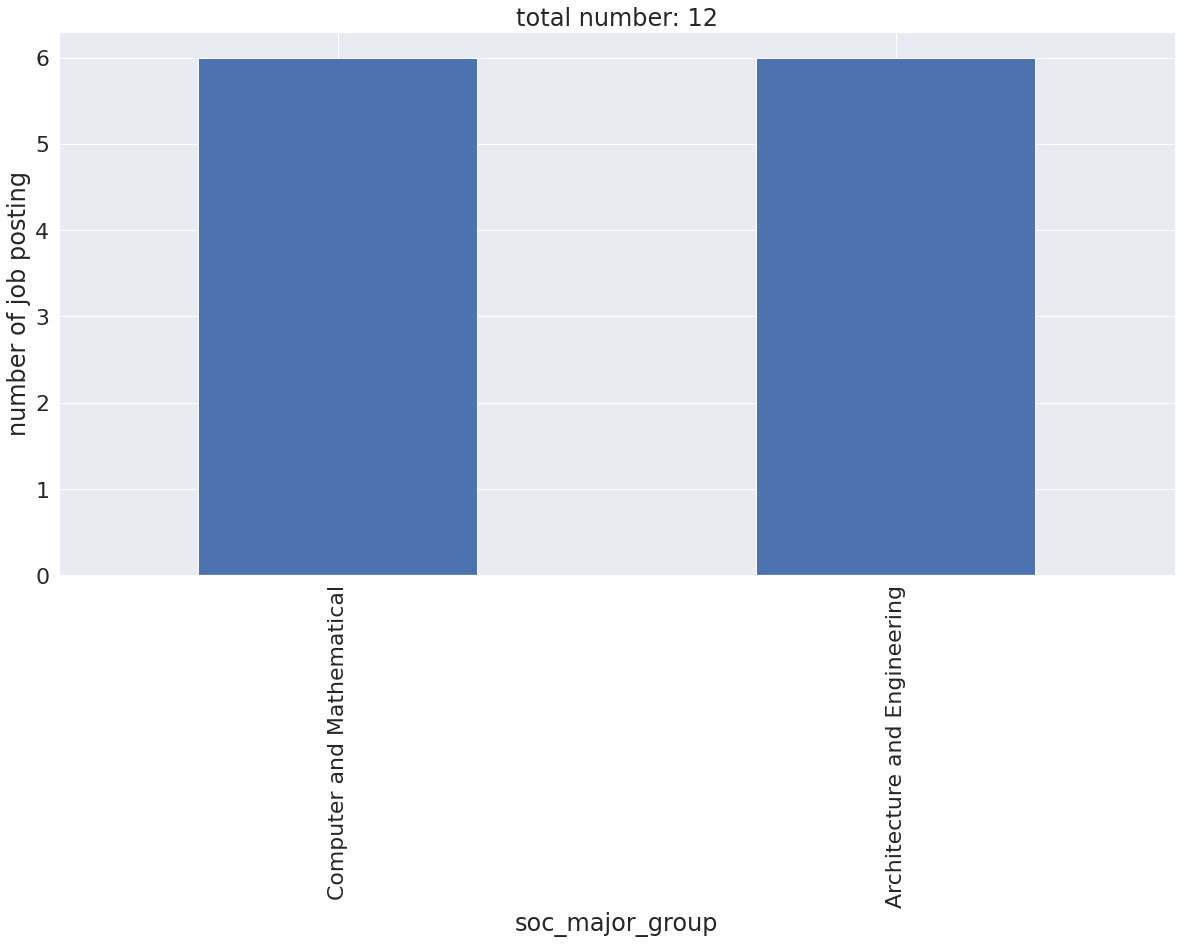

In [140]:
from skills_ml.job_postings.filtering import JobPostingFilterer

def is_tech_jobs(job):
    if job['onet_soc_code'][:2] in ['15', '17', '19']:
        return True
    else:
        return False

tech_jobs = JobPostingFilterer(
    job_posting_generator=SampleJobPosting(sample),
    filter_funcs=[is_tech_jobs]
)
from skills_ml.ontologies.onet import majorgroupname
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style="darkgrid", font_scale=2)
%matplotlib inline

# major group distribution plotting function

def plot_major_group_distribution(job_postings):
    c = Counter()
    for job in job_postings:
        c.update([job['onet_soc_code'][:2]])
    s = pd.Series(c).sort_index()
    s.index = s.index.map(majorgroupname)
    ax = s.plot.bar(figsize=(20,10),rot=90)
    ax.set_xlabel('soc_major_group')
    ax.set_ylabel('number of job posting')
    ax.set_title(f"total number: {s.sum()}")
    return s

plot_major_group_distribution(tech_jobs)

#### We re-run the above anlaysis using Kaggle job postings, which is more structured than LinkedIn

In [6]:
job_posts = pd.read_csv(os.path.join(db_dir, "data job posts.csv"))
job_posts = job_posts[job_posts["JobDescription"].notna()]

In [12]:
class DFJobPostingCollection:
    def __init__(self, df: pd.DataFrame):
        self.df = df
    def __iter__(self):
        for idx , ser in self.df.iterrows():
            d = {
                "description": ser["JobDescription"],
                # "experienceRequirements": ser["Level"],
                "id": idx,
                "@type": "JobPosting",
                "title": ser["Title"]
                }
            yield d
    def __len__(self):
        return len(self.df)

for i in DFJobPostingCollection(job_posts):
    print(i)
    break

{'description': "AMERIA Investment Consulting Company is seeking a\r\nChief Financial Officer. This position manages the company's fiscal and\r\nadministrative functions, provides highly responsible and technically\r\ncomplex staff assistance to the Executive Director. The work performed\r\nrequires a high level of technical proficiency in financial management\r\nand investment management, as well as management, supervisory, and\r\nadministrative skills.", 'id': 0, '@type': 'JobPosting', 'title': 'Chief Financial Officer'}


In [20]:
# full_onet = Onet()
full_onet = onet

skill_extractors = [
    # SectionExtractSkillExtractor(),
    SkillEndingPatternExtractor(only_bulleted_lines=False),
    AbilityEndingPatternExtractor(only_bulleted_lines=False),
    # Symmetric Delete spelling correction algorithm
    FuzzyMatchSkillExtractor(full_onet.competency_framework),
    ExactMatchSkillExtractor(full_onet.competency_framework),
    SocScopedExactMatchSkillExtractor(full_onet)
]
metric_ontologies = [
    full_onet,
    full_onet.filter_by(lambda edge: 'Knowledge' in edge.competency.categories, competency_name='onet_knowledge', competency_description='ONET Knowledge'),
    full_onet.filter_by(lambda edge: 'Abilities' in edge.competency.categories, competency_name='onet_ability', competency_description='ONET Ability'),
    full_onet.filter_by(lambda edge: 'Skills' in edge.competency.categories, competency_name='onet_skill', competency_description='ONET Skill')
]
metrics = [
    TotalOccurrences(),
    TotalVocabularySize(),
]
for metric_ontology in metric_ontologies:
    # The percentage of competencies in an ontology which are present in the candidate skills
    metrics.append(OntologyCompetencyRecall(metric_ontology))

In [14]:
results = []
sample = DFJobPostingCollection(job_posts)
for skill_extractor in skill_extractors:
    print(f'Evaluating skill extractor {skill_extractor.name}')
    candidate_skills = [skill for i in sample for skill in skill_extractor.candidate_skills(i)]

    computed_metrics = metrics_for_candidate_skills(
        candidate_skills=candidate_skills,
        sample=sample,
        metrics=metrics
    )
    print(computed_metrics)
    results.append(computed_metrics)

Evaluating skill extractor noun_phrase_skill
{'total_candidate_skills': 311, 'total_vocabulary_size': 115, 'onet_ksat_competency_recall': 0.0, 'onet_knowledge_competency_recall': 0.0, 'onet_ability_competency_recall': 0.0, 'onet_skill_competency_recall': 0.0}
Evaluating skill extractor noun_phrase_ability
{'total_candidate_skills': 21, 'total_vocabulary_size': 12, 'onet_ksat_competency_recall': 0.0, 'onet_knowledge_competency_recall': 0.0, 'onet_ability_competency_recall': 0.0, 'onet_skill_competency_recall': 0.0}
Evaluating skill extractor onet_ksat_fuzzy_thresh88_maxdist4_maxngram5
{'total_candidate_skills': 6251, 'total_vocabulary_size': 251, 'onet_ksat_competency_recall': 0.007149770520465828, 'onet_knowledge_competency_recall': 0.5454545454545454, 'onet_ability_competency_recall': 0.038461538461538464, 'onet_skill_competency_recall': 0.5142857142857142}
Evaluating skill extractor onet_ksat_exact_match
{'total_candidate_skills': 6690, 'total_vocabulary_size': 207, 'onet_ksat_compet

In [15]:
metric_names = results[0].keys()
skill_extractor_metric = []
for i, skill_extractor in enumerate(skill_extractors):
    skill_extractor_metric.append([
        results[i][name]
        for name in metric_names
    ])
skill_extractor_metric_df = pd.DataFrame(
    skill_extractor_metric,
    columns=metric_names,
    index=[skill_extractor.name for skill_extractor in skill_extractors]
)
skill_extractor_metric_df

,total_candidate_skills,total_vocabulary_size,onet_ksat_competency_recall,onet_knowledge_competency_recall,onet_ability_competency_recall,onet_skill_competency_recall
noun_phrase_skill,311,115,0.000000,0.000000,0.000000,0.000000
noun_phrase_ability,21,12,0.000000,0.000000,0.000000,0.000000
onet_ksat_fuzzy_thresh88_maxdist4_maxngram5,6251,251,0.007150,0.545455,0.038462,0.514286
onet_ksat_exact_match,6690,207,0.006463,0.545455,0.038462,0.514286
onet_ksat_occscoped_exact_match,0,0,0.000000,0.000000,0.000000,0.000000


In [19]:
best = skill_extractors[np.argmax(skill_extractor_metric_df.iloc[:,0])]
k = 0
for s in sample:
    for i in best.candidate_skills(s):
        print("skill: ", i.skill_name, ", id", i.matched_skill_identifier)
        k += 1
    if k > 10: break

skill:  coordination , id 2.B.1.b
skill:  design , id 2.C.3.c
skill:  levels , id 27111802
skill:  impact , id 43232610-ImPACT
skill:  levels , id 27111802
skill:  monitoring , id 2.A.2.d
skill:  reduce , id 43232605-REDUCE
skill:  self , id 43232405-Self
skill:  impact , id 43232610-ImPACT
skill:  harvest , id 43232605-HARVEST
skill:  design , id 2.C.3.c
skill:  monitoring , id 2.A.2.d


Using linked job posting of software engineer

In [15]:
linkedin = pd.read_csv("db/2020-12-09-linkedin.csv", encoding="ISO-8859-1")
linkedin.rename({"Post": "Title", "Description": "JobDescription"}, axis=1, inplace=True)
for i in DFJobPostingCollection(linkedin):
    print(i)
    break

{'description': 'Direct message the job poster from Jobot Reed Kellick Recruiting Manager at Jobot', 'id': 0, '@type': 'JobPosting', 'title': 'Senior Front End Software Engineer'}


In [16]:
results = []
sample = DFJobPostingCollection(linkedin)
for skill_extractor in skill_extractors:
    print(f'Evaluating skill extractor {skill_extractor.name}')
    candidate_skills = [skill for i in sample for skill in skill_extractor.candidate_skills(i)]

    computed_metrics = metrics_for_candidate_skills(
        candidate_skills=candidate_skills,
        sample=sample,
        metrics=metrics
    )
    print(computed_metrics)
    results.append(computed_metrics)

Evaluating skill extractor noun_phrase_skill
{'total_candidate_skills': 2, 'total_vocabulary_size': 2, 'onet_ksat_competency_recall': 0.0, 'onet_knowledge_competency_recall': 0.0, 'onet_ability_competency_recall': 0.0, 'onet_skill_competency_recall': 0.0}
Evaluating skill extractor noun_phrase_ability
{'total_candidate_skills': 0, 'total_vocabulary_size': 0, 'onet_ksat_competency_recall': 0.0, 'onet_knowledge_competency_recall': 0.0, 'onet_ability_competency_recall': 0.0, 'onet_skill_competency_recall': 0.0}
Evaluating skill extractor onet_ksat_fuzzy_thresh88_maxdist4_maxngram5
{'total_candidate_skills': 80, 'total_vocabulary_size': 21, 'onet_ksat_competency_recall': 0.0006556558119204471, 'onet_knowledge_competency_recall': 0.030303030303030304, 'onet_ability_competency_recall': 0.0, 'onet_skill_competency_recall': 0.08571428571428572}
Evaluating skill extractor onet_ksat_exact_match
{'total_candidate_skills': 83, 'total_vocabulary_size': 22, 'onet_ksat_competency_recall': 0.000686877

In [69]:
mathematicans = onet.filter_by(
    lambda edge: "Mathematicians" in edge.occupation.name
)
mathematicans.competency_framework.name = "mathematicians"
mathematicans.competency_framework.description = "mathematicians competency"
best = FuzzyMatchSkillExtractor(mathematicans.competency_framework)
candidate_skills = [skill for i in sample for skill in best.candidate_skills(i)]
print("skills required by mathematicians from", len(sample), "software engineering job postings")
for s in candidate_skills:
    print("\t", s.skill_name)

print("[note C programming langauge is in the list of required skills of mathematicians, but our skill extractor can also find c++]")

skills required by mathematicians from 49 software engineering job postings
	 science
	 python
	 javascript
	 science
	 science
	 c++
	 python
	 c++
	 python
	 c++
	 r
	 c++
	 python
[note C programming langauge is in the list of required skills of mathematicians, but our skill extractor can also find c++]


### NER

We also began our exploration into Net Entity Recognizers (NER) as a beetter approach to extract skills. We're currently using Use FlairNLP's Context Embedding layers.

In order to better train our dataset, we have to find an annotated data that contains skills. Resumes will serve better than job postings in this case because they contain labeled skills. Resumes are more specific and more likely to find a skill that are directly related to the jobs, while job postings some times are abstract and general as shown in EDA. Most often job postings would contains many unrelated infomation like location and salary. To be clear, these resumes are only used for training. We use resume data cleaned from DataTurks to train our model.

In [109]:
cv_train = pd.read_json(db_dir/"545_cvs_train.json",lines=True)
from sklearn.model_selection import train_test_split
cv_train, cv_val = train_test_split(cv_train, train_size=0.9, shuffle=True, seed=42)

In [110]:
cv_test = pd.read_json(db_dir/"50_cvs_test.json",lines=True)

In [111]:
cv_train.shape, cv_val.shape, cv_test.shape

((490, 5), (55, 5), (50, 5))

In [112]:
def display_label(i):
    s = cv_train.iloc[i].text
    for start, end, label in cv_train.iloc[i].labels:
        print(s[start:end].replace("\n", " "), "------>", label)
display_label(0)

Sales Consultant ------> Designation
Miami, Fl ------> Location
Keisha Swinson ------> Name
xxxxx@gmail.com ------> Email Address
negotiating ------> Soft Skills
sales experience ------> Job Specific Skills
budgeting ------> Job Specific Skills
planning ------> Job Specific Skills
analytical ------> Soft Skills
good team ------> Soft Skills
multitasking ------> Soft Skills
Air Phone co. ------> Companies worked at
2000 till date ------> Years of Experience
Sales Consultanat ------> Designation
sales ------> Job Specific Skills
promotions ------> Job Specific Skills
training ------> Soft Skills
new business opportunities ------> Job Specific Skills
Price negotiations ------> Job Specific Skills
Phone Sales and Sales Co. ------> Companies worked at
1999- 2000 ------> Years of Experience
Sales Representative ------> Designation
new business opportunities ------> Job Specific Skills
Price negotiations ------> Job Specific Skills
Bachelors degree in Arts ------> Degree
University of Florida

In [113]:
labels_ct = defaultdict(int)
for i in range(len(cv_train)):
    for start, end, label in cv_train.iloc[i]["labels"]:
        labels_ct[label] += 1
labels_ct

defaultdict(int,
            {'Designation': 3081,
             'Location': 2512,
             'Name': 707,
             'Email Address': 567,
             'Soft Skills': 1696,
             'Job Specific Skills': 5099,
             'Companies worked at': 2085,
             'Years of Experience': 2025,
             'Degree': 1077,
             'College Name': 1129,
             'Graduation Year': 583,
             'Tech Tools': 6199})

In [143]:
import spacy
import re
nlp = spacy.load("en_core_web_sm")

def create_data(df, filepath):
    with open(filepath , 'w') as f:
        for text, labels in zip(df.text, df.labels):
            n = len(text)
            cur = 0
            labels = sorted(labels, key=lambda t: t[0])
            
            write_words = []
            while cur < n:
                start,end, label = labels[0] if labels else (n,n,"")
                label = label.replace(" ", "")
                if cur == start:
                    label_str = text[start:end].split()
                    write_words.append((label_str[0], f"B-{label}"))
                    for s in label_str[1:]:
                        write_words.append((s, f"I-{label}"))
                    cur = end + 1
                    labels.pop(0)
                else:
                    unlabeled_strs = text[cur:start]
                    unlabeled_strs = re.sub(r"\n+",  "\n", unlabeled_strs)
                    for s in nlp(unlabeled_strs):
                        s = s.text
                        if re.match(r"\s+", s):
                            write_words.append((s, "<eos>"))
                        elif s!="":
                            write_words.append((s, "O"))
                    cur = start
            if len(write_words) > 2000:
                continue
            for word,label in write_words:
                if label == "<eos>":
                    f.write("\n")
                else:
                    f.write(word + " " + label + "\n")
            
            
create_data(cv_train, "train.txt")
create_data(cv_val, "val.txt")
create_data(cv_test, "test.txt")

For the rest please see the trainning notebook on google colab

## Next Steps

    1) Better skill extracting by improving training of NER model.
    2) Combine new scraping information with skills in curreent database
    3) Build relevance scores between skills and jobs. Some ideas:
        - Simple count of relevant words
        - Graph algorithms (centrality, components)
        - NLP (hierarchical softmax)